In [1]:
! nvidia-smi

Fri Jul  3 20:51:45 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#prepare data and env


In [3]:
! pip install --upgrade --force-reinstall --no-deps kaggle
! mkdir -p ~/.kaggle/
! cp '/content/drive/My Drive/Global_Wheat_Detection/kaggle.json' ~/.kaggle/ #please upload your kaggle.json to drive
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c global-wheat-detection
# ! kaggle datasets download -d m1nglei/wheat-data-all 
# ! unzip '/content/wheat-data-all.zip' -d '/content/global-wheat-detection' > /dev/null
! unzip '/content/global-wheat-detection.zip' -d '/content/global-wheat-detection' > /dev/null

     |████████████████████████████████| 61kB 1.9MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-cp36-none-any.whl size=72859 sha256=de19e683fa7f00a6bc2e9fd38b38c14bbc7bf43688998b2339c208c5dc8613f9
  Stored in directory: /root/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674
Successfully built kaggle
  Found existing installation: kaggle 1.5.6
    Uninstalling kaggle-1.5.6:
      Successfully uninstalled kaggle-1.5.6
100% 606M/607M [00:03<00:00, 156MB/s]
100% 607M/607M [00:03<00:00, 190MB/s]


In [4]:
! pip install --upgrade --force-reinstall --no-deps albumentations

     |████████████████████████████████| 122kB 2.8MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=64378 sha256=d93e206a274c7f88b137be2f13bfade6e05aea367561884fe40fe0abb644b7f6
  Stored in directory: /root/.cache/pip/wheels/f0/a0/61/e50f93165a5ec7e7f5d65064e513239505bc4c06d2289557d3
Successfully built albumentations
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
! git clone https://github.com/open-mmlab/mmcv.git /content/mmcv/
%cd /content/mmcv
! pip install -e .

In [ ]:
! git clone https://github.com/WangLibo1995/mmdetection-v2-with-mosaic-data-augmentation.git /content/mmdetection/  
%cd /content/mmdetection
! pip install -r requirements/build.txt
! pip install "git+https://github.com/open-mmlab/cocoapi.git#subdirectory=pycocotools"
! python setup.py develop

In [8]:
#!wget -c https://www.cs.jhu.edu/~syqiao/DetectoRS/DetectoRS_X101-ed983634.pth -O /content/DetectoRS_x101.pth

In [9]:
# !wget -c http://cs.jhu.edu/~syqiao/DetectoRS/DetectoRS_R50-0f1c8080.pth -O /content/DetectoRS_50.pth

In [10]:
!wget -c https://open-mmlab.s3.ap-northeast-2.amazonaws.com/mmdetection/v2.0/detectors/detectors_cascade_rcnn_r50_1x_coco/detectors_cascade_rcnn_r50_1x_coco-0db1ab6a.pth -O /content/DetectoRS_box_50.pth

--2020-07-03 21:15:36--  https://open-mmlab.s3.ap-northeast-2.amazonaws.com/mmdetection/v2.0/detectors/detectors_cascade_rcnn_r50_1x_coco/detectors_cascade_rcnn_r50_1x_coco-0db1ab6a.pth
Resolving open-mmlab.s3.ap-northeast-2.amazonaws.com (open-mmlab.s3.ap-northeast-2.amazonaws.com)... 52.219.58.87
Connecting to open-mmlab.s3.ap-northeast-2.amazonaws.com (open-mmlab.s3.ap-northeast-2.amazonaws.com)|52.219.58.87|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 496633583 (474M) [application/x-www-form-urlencoded]
Saving to: ‘/content/DetectoRS_box_50.pth’

/content/DetectoRS_ 100%[===================>] 473.63M  15.6MB/s    in 32s     

2020-07-03 21:16:09 (14.9 MB/s) - ‘/content/DetectoRS_box_50.pth’ saved [496633583/496633583]



# Restart the code executor

In [2]:
import mmcv
from mmcv import Config
from mmcv.runner import load_checkpoint
from mmcv.parallel import MMDataParallel
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
from mmdet.models import build_detector
from mmdet.apis import single_gpu_test
from mmdet.datasets import build_dataloader, build_dataset
import cv2
import pandas as pd
import numpy as np
import os
import re
import json

from PIL import Image
import matplotlib.pyplot as plt
import torch

# csv2coco and 5-flod

In [3]:
def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

def marking_pre(csv_file, debug=False):
    df = pd.read_csv(csv_file)
    df['x'] = -1
    df['y'] = -1
    df['w'] = -1
    df['h'] = -1
    
    df[['x', 'y', 'w', 'h']] = np.stack(df['bbox'].apply(lambda x: expand_bbox(x)))
    df.drop(columns=['bbox'], inplace=True)
    df['xmin'] = df['x'].astype(np.float)
    df['ymin'] = df['y'].astype(np.float)
    df['w'] = df['w'].astype(np.float)
    df['h'] = df['h'].astype(np.float)
    df['area'] = df['w']*df['h']
    error_bbox = [100648.0, 145360.0, 149744.0, 119790.0, 106743.0]
    df = df[df['area']<154200.0]
    df = df[~df['area'].isin(error_bbox)]
    df = df[df['w']>=10.0]
    df = df[df['h']>=10.0]
    df['xmax'] = df.apply(lambda x: x['xmin'] + x['w'], axis=1)
    df['ymax'] = df.apply(lambda x: x['ymin'] + x['h'], axis=1)
    df['category'] = 'wheat'
    df['image_id'] = df.apply(lambda x: x['image_id'] + '.jpg', axis=1)
    df.drop(columns=['x', 'y', 'w', 'h','width','height','area'], inplace=True)
    print(df.head())
    if debug:
      df =df[:1500]
    return df

In [4]:
import glob
import os
import shutil
from IPython import embed
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
np.random.seed(42)

#{"background":1}
classname_to_id = {"wheat": 0}

class Csv2CoCo:

    def __init__(self,image_dir,total_annos):
        self.images = []
        self.annotations = []
        self.categories = []
        self.img_id = 0
        self.ann_id = 0
        self.image_dir = image_dir
        self.total_annos = total_annos

    def save_coco_json(self, instance, save_path):
        json.dump(instance, open(save_path, 'w'), ensure_ascii=False, indent=2)  # indent=2 更加美观显示

    # 由txt文件构建COCO
    def to_coco(self, keys):
        self._init_categories()
        for key in keys:
            self.images.append(self._image(key))
            shapes = self.total_annos[key]
            for shape in shapes:
                bboxi = []
                for cor in shape[:-1]:
                    bboxi.append(int(float(cor)))
                label = shape[-1]
                annotation = self._annotation(bboxi,label)
                self.annotations.append(annotation)
                self.ann_id += 1
            self.img_id += 1
        instance = {}
        instance['info'] = 'Libo Wang created'
        instance['license'] = ['license']
        instance['images'] = self.images
        instance['annotations'] = self.annotations
        instance['categories'] = self.categories
        return instance

    # 构建类别
    def _init_categories(self):
        for k, v in classname_to_id.items():
            category = {}
            category['id'] = v
            category['name'] = k
            self.categories.append(category)

    # 构建COCO的image字段
    def _image(self, path):
        image = {}
        img_path = self.image_dir + path
        print(img_path)
        img = cv2.imread(img_path)
        image['height'] = img.shape[0]
        image['width'] = img.shape[1]
        image['id'] = self.img_id
        image['file_name'] = path
        return image

    # 构建COCO的annotation字段
    def _annotation(self, shape, label):
        # label = shape[-1]
        points = shape[:4]
        annotation = {}
        annotation['id'] = self.ann_id
        annotation['image_id'] = self.img_id
        annotation['category_id'] = int(classname_to_id[label])
        annotation['segmentation'] = self._get_seg(points)
        annotation['bbox'] = self._get_box(points)
        annotation['iscrowd'] = 0
        annotation['area'] = self._get_area(points)
        return annotation

    # COCO的格式： [x1,y1,w,h] 对应COCO的bbox格式
    def _get_box(self, points):
        min_x = points[0]
        min_y = points[1]
        max_x = points[2]
        max_y = points[3]
        return [min_x, min_y, max_x - min_x, max_y - min_y]
    # 计算面积
    def _get_area(self, points):
        min_x = points[0]
        min_y = points[1]
        max_x = points[2]
        max_y = points[3]
        return (max_x - min_x+1) * (max_y - min_y+1)
    # segmentation
    def _get_seg(self, points):
        min_x = points[0]
        min_y = points[1]
        max_x = points[2]
        max_y = points[3]
        h = max_y - min_y
        w = max_x - min_x
        a = []
        a.append([min_x,min_y, min_x,min_y+0.5*h, min_x,max_y, min_x+0.5*w,max_y, max_x,max_y, max_x,max_y-0.5*h, max_x,min_y, max_x-0.5*w,min_y])
        return a
   
def sk_5fold(marking,fold_number):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    df_folds = marking[['image_id']].copy()
    df_folds.loc[:, 'bbox_count'] = 1
    df_folds = df_folds.groupby('image_id').count()
    df_folds.loc[:, 'source'] = marking[['image_id', 'source']].groupby('image_id').min()['source']
    df_folds.loc[:, 'stratify_group'] = np.char.add(
        df_folds['source'].values.astype(str),
        df_folds['bbox_count'].apply(lambda x: f'_{x // 15}').values.astype(str)
    )
    df_folds.loc[:, 'fold'] = 0

    for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['stratify_group'])):
        df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number
    
    return df_folds
    
    
    
def with_5fold_to_coco(csv_file,image_dir,saved_coco_path,fold_number,debug):
#     csv_file = "train_df.csv"
#     image_dir = "/content/global-wheat-detection/train/"
#     saved_coco_path = "/content/wheat"
    # 整合csv格式标注文件
    total_csv_annotations = {}
    marking = marking_pre(csv_file, debug)
    
    df_folds = sk_5fold(marking,fold_number)
    train_keys = df_folds[df_folds['fold'] != fold_number].index.values
    val_keys = df_folds[df_folds['fold'] == fold_number].index.values
    
    marking = marking.drop(columns=['source'], axis=1)
    print(marking.head())
    annotations = marking.values
    for annotation in annotations:
        key = annotation[0].split(os.sep)[-1]
        value = np.array([annotation[1:]])
        if key in total_csv_annotations.keys():
            total_csv_annotations[key] = np.concatenate((total_csv_annotations[key],value),axis=0)
        else:
            total_csv_annotations[key] = value
    # 按照键值划分数据
    total_keys = list(total_csv_annotations.keys())
    print("train_n:", len(train_keys), 'val_n:', len(val_keys), 'total_n:', len(total_keys))
    # 创建必须的文件夹      
    annotations_path = f'{saved_coco_path}/annotations/'
    train_path = f'{saved_coco_path}/train2017'
    val_path = f'{saved_coco_path}/val2017'
    if not os.path.exists(annotations_path):
        os.makedirs(annotations_path)
    if not os.path.exists(train_path):
        os.makedirs(train_path)
    if not os.path.exists(val_path):
        os.makedirs(val_path)
    # 把训练集转化为COCO的json格式
    l2c_train = Csv2CoCo(image_dir=image_dir,total_annos=total_csv_annotations)
    train_instance = l2c_train.to_coco(train_keys)
    l2c_train.save_coco_json(train_instance, f'{annotations_path}instances_train2017.json')
    for file in train_keys:
        shutil.copy(image_dir+file,train_path)
    for file in val_keys:
        shutil.copy(image_dir+file,val_path)
    # 把验证集转化为COCO的json格式
    l2c_val = Csv2CoCo(image_dir=image_dir,total_annos=total_csv_annotations)
    val_instance = l2c_val.to_coco(val_keys)
    l2c_val.save_coco_json(val_instance, f'{annotations_path}instances_val2017.json')

# File Path

In [5]:
csv_file = '/content/global-wheat-detection/train.csv'
image_dir = '/content/global-wheat-detection/train/'
saved_coco_path = '/content/mmdetection/data/coco'
fold_number = 0
debug = False

# Run Data Format Conversion

In [6]:
with_5fold_to_coco(csv_file,image_dir,saved_coco_path,fold_number,debug)

        image_id   source   xmin   ymin   xmax   ymax category
0  b6ab77fd7.jpg  usask_1  834.0  222.0  890.0  258.0    wheat
1  b6ab77fd7.jpg  usask_1  226.0  548.0  356.0  606.0    wheat
2  b6ab77fd7.jpg  usask_1  377.0  504.0  451.0  664.0    wheat
3  b6ab77fd7.jpg  usask_1  834.0   95.0  943.0  202.0    wheat
4  b6ab77fd7.jpg  usask_1   26.0  144.0  150.0  261.0    wheat


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


        image_id   xmin   ymin   xmax   ymax category
0  b6ab77fd7.jpg  834.0  222.0  890.0  258.0    wheat
1  b6ab77fd7.jpg  226.0  548.0  356.0  606.0    wheat
2  b6ab77fd7.jpg  377.0  504.0  451.0  664.0    wheat
3  b6ab77fd7.jpg  834.0   95.0  943.0  202.0    wheat
4  b6ab77fd7.jpg   26.0  144.0  150.0  261.0    wheat
train_n: 2698 val_n: 675 total_n: 3373
/content/global-wheat-detection/train/00333207f.jpg
/content/global-wheat-detection/train/005b0d8bb.jpg
/content/global-wheat-detection/train/006a994f7.jpg
/content/global-wheat-detection/train/00b5fefed.jpg
/content/global-wheat-detection/train/00b70a919.jpg
/content/global-wheat-detection/train/00ea5e5ee.jpg
/content/global-wheat-detection/train/010c93b99.jpg
/content/global-wheat-detection/train/010dbcc8f.jpg
/content/global-wheat-detection/train/01189a3c3.jpg
/content/global-wheat-detection/train/0126b7d11.jpg
/content/global-wheat-detection/train/013669953.jpg
/content/global-wheat-detection/train/01397a84c.jpg
/content/glob

# Show Dataset

In [ ]:
%cd '/content/mmdetection'
!python tools/browse_dataset.py /content/mmdetection/configs/detectors/detectors_cascade_rcnn_r50_1x_coco.py \
--output-dir /content/fig \
--not-show

/content/mmdetection
loading annotations into memory...
Done (t=0.93s)
creating index...
index created!
[  ] 379/2698, 8.1 task/s, elapsed: 47s, ETA:   287s

380


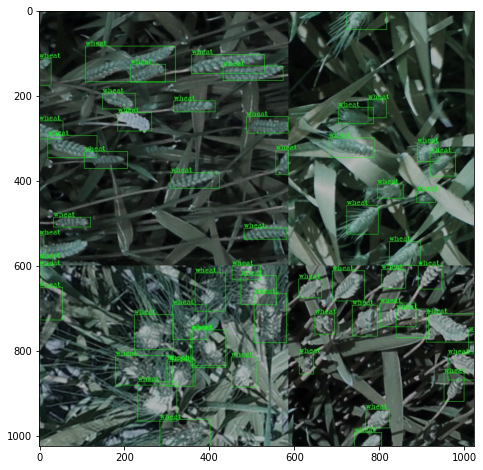

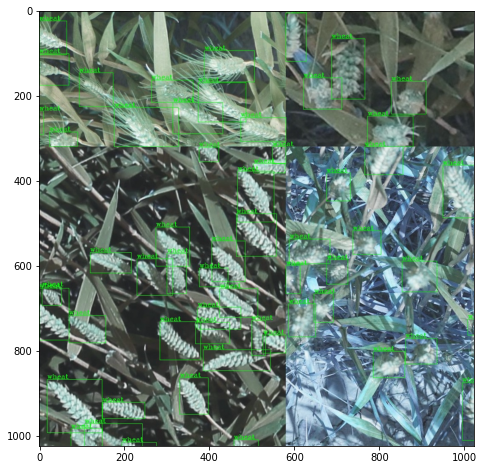

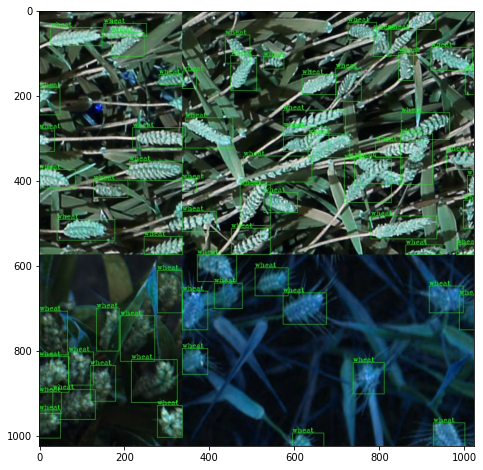

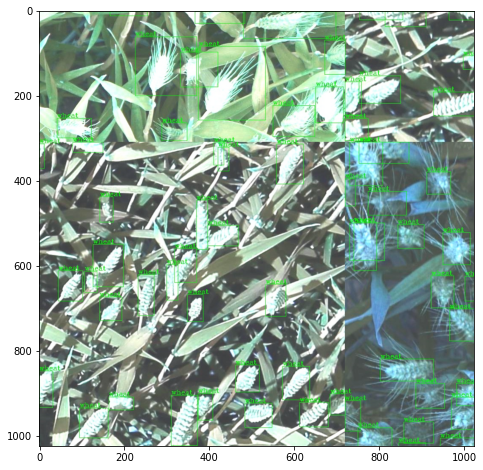

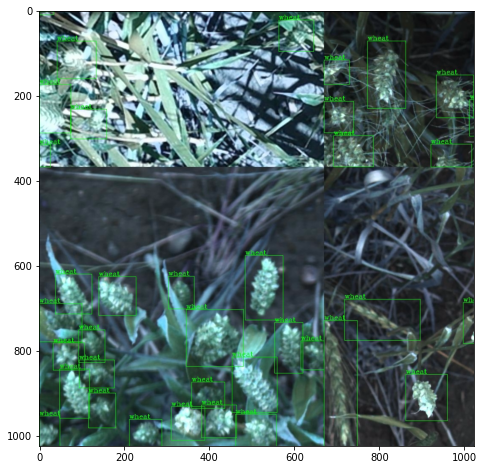

In [1]:
import os
import mmcv
import matplotlib.pyplot as plt

image_list = os.listdir('/content/fig')
print(len(image_list))
for image_id in image_list[-5:]:
  fig, ax = plt.subplots(1, 1, figsize=(16, 8))
  img = mmcv.imread(f'/content/fig/{image_id}')
  ax.imshow(img)

# Training

In [ ]:
%cd '/content/mmdetection'
!python tools/train.py /content/mmdetection/configs/detectors/detectors_cascade_rcnn_r50_1x_coco.py \
--work-dir "/content/drive/My Drive/Global_Wheat_Detection/mmdetv2-resnet50_ft-debug" \
--gpus 1 \
--seed 42 \
--load-from /content/DetectoRS_box_50.pth 

/content/mmdetection
2020-07-03 21:40:05,688 - mmdet - INFO - Environment info:
------------------------------------------------------------
sys.platform: linux
Python: 3.6.9 (default, Apr 18 2020, 01:56:04) [GCC 8.4.0]
CUDA available: True
CUDA_HOME: /usr/local/cuda
NVCC: Cuda compilation tools, release 10.1, V10.1.243
GPU 0: Tesla P100-PCIE-16GB
GCC: gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
PyTorch: 1.5.1+cu101
PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2019.0.5 Product Build 20190808 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v0.21.1 (Git Hash 7d2fd500bc78936d1d648ca713b901012f470dbc)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 10.1
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_61,code=sm_61;-gencode;arch=compu

# Testing

In [ ]:
# %cd /content/mmdetection
# !python tools/test.py \
# --config /content/mmdetection/configs/DetectoRS/My_DetectoRS_resnet101_from_x.py \
# --checkpoint "/content/drive/My Drive/Global_Wheat_Detection/mmdet-resnet101/epoch_2.pth" \
# --eval 'bbox' \
# --out "/content/drive/My Drive/Global_Wheat_Detection/mmdet-resnet101/result.pkl" 

In [ ]:
# cfg_path = '/content/mmdetection/configs/DetectoRS/My_DetectoRS_resnet101_from_x.py'
# cp_path = '/content/drive/My Drive/Global_Wheat_Detection/mmdet-resnet101/epoch_2.pth'

# # build the model from a config file and a checkpoint file
# model = init_detector(cfg_path, cp_path, device='cuda:0')

In [ ]:
# img = '/content/mmdetection/data/coco/train2017/00333207f.jpg'
# img = mmcv.imread(img)# or img = mmcv.imread(img), which will only load it once
# result = inference_detector(model, img)
# #print(result)
# show_result_pyplot(img, result, model.CLASSES)
# torch.cuda.empty_cache()